In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
###Common imports
from Bio import SeqIO
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats

# #My helper library for this analysis
import sequencing_analysis_library as SAL

In [3]:
genome_file = '/Users/adamhockenberry/Projects/Neisseria/Data/Genomes/fa1090.gb'
genome = list(SeqIO.parse(genome_file, 'genbank'))[0]

In [4]:
sample_files = ['SQ-1', 'SQ-2', 'SQ-3', 'SQ-4', 'SQ-5', 'SQ-6']
# sample_files = ['SQ-1', 'SQ-3', 'SQ-5', 'SQ-7', 'SQ-9', 'SQ-11']


organism = 'Neisseria'
file_ending = '_15_100_all'

fpkm_dict_meta, feature_dict, sequencing_dict_meta_f, sequencing_dict_meta_r =\
        SAL.wiggle_to_sequencing(genome, sample_files, organism, file_ending, feature_type='CDS')

SQ-1: Total reads mapped:36867803.00010039 Percentage mapped to feature:86.60295738598663
SQ-2: Total reads mapped:27278803.73762074 Percentage mapped to feature:83.59493058432895
SQ-3: Total reads mapped:23491709.157121595 Percentage mapped to feature:85.64459481860725
SQ-4: Total reads mapped:16190652.508570375 Percentage mapped to feature:85.36258437854744
SQ-5: Total reads mapped:30839689.291754577 Percentage mapped to feature:86.67537726062827
SQ-6: Total reads mapped:21644564.32345894 Percentage mapped to feature:87.998864419237


In [5]:
total_dict = {}
for sample_file in sample_files:
    total_dict[sample_file] = np.sum(list(sequencing_dict_meta_f[sample_file].values())) +\
                                np.sum(list(sequencing_dict_meta_r[sample_file].values()))

In [6]:
len(genome.seq)

2153922

In [42]:
control_labels = ['SQ-1', 'SQ-3', 'SQ-5']
treatment_labels = ['SQ-2', 'SQ-4', 'SQ-6']
# treatment_labels = ['SQ-7', 'SQ-9', 'SQ-11']


window_size = 100
step_size = 10
beginning, end = (0, 200000)


ctrl_fpkm_avg_plus = []
ctrl_fpkm_avg_minus = []
treatment_fpkm_avg_plus = []
treatment_fpkm_avg_minus = []

p_vals_plus = []
p_vals_minus = []

xcoords = []

for i in range(beginning,end-window_size, step_size):
    treatment_vals_plus = []
    control_vals_plus = []
    treatment_vals_minus = []
    control_vals_minus = []
    for label in total_dict.keys():
        temp_plus = []
        temp_minus = []
        for j in range(i, i+window_size):
            try:
                temp_plus.append(sequencing_dict_meta_f[label][j])
            except KeyError:
                temp_plus.append(0)
            try:
                temp_minus.append(sequencing_dict_meta_r[label][j])
            except KeyError:
                temp_minus.append(0)
                        
        fpkm_plus = (np.sum(temp_plus) * 1000000000) / (len(temp_plus) * total_dict[label])
        fpkm_minus = (np.sum(temp_minus) * 1000000000) / (len(temp_plus) * total_dict[label])

        if label in control_labels:
            control_vals_plus.append(fpkm_plus)
            control_vals_minus.append(fpkm_minus)

        elif label in treatment_labels:
            treatment_vals_plus.append(fpkm_plus)
            treatment_vals_minus.append(fpkm_minus)
    
    ctrl_fpkm_avg_plus.append(np.mean(control_vals_plus))
    ctrl_fpkm_avg_minus.append(np.mean(control_vals_minus))
    treatment_fpkm_avg_plus.append(np.mean(treatment_vals_plus))
    treatment_fpkm_avg_minus.append(np.mean(treatment_vals_minus))


    t, p = stats.ttest_ind(control_vals_plus, treatment_vals_plus, equal_var=False)
    p_vals_plus.append(p)
    
    t, p = stats.ttest_ind(control_vals_minus, treatment_vals_minus, equal_var=False)
    p_vals_minus.append(p)
    
    xcoords.append(i)

In [44]:
plus_features = []
minus_features = []
for feature in feature_dict:
    feature_beg = int(feature_dict[feature].location.start)
    feature_end = int(feature_dict[feature].location.end)
    if feature_beg in range(beginning, end) and feature_end in range(beginning, end):
        if feature_dict[feature].strand == 1:
            plus_features.append((feature_beg, feature_end))
        elif feature_dict[feature].strand == -1:
            minus_features.append((feature_beg, feature_end))

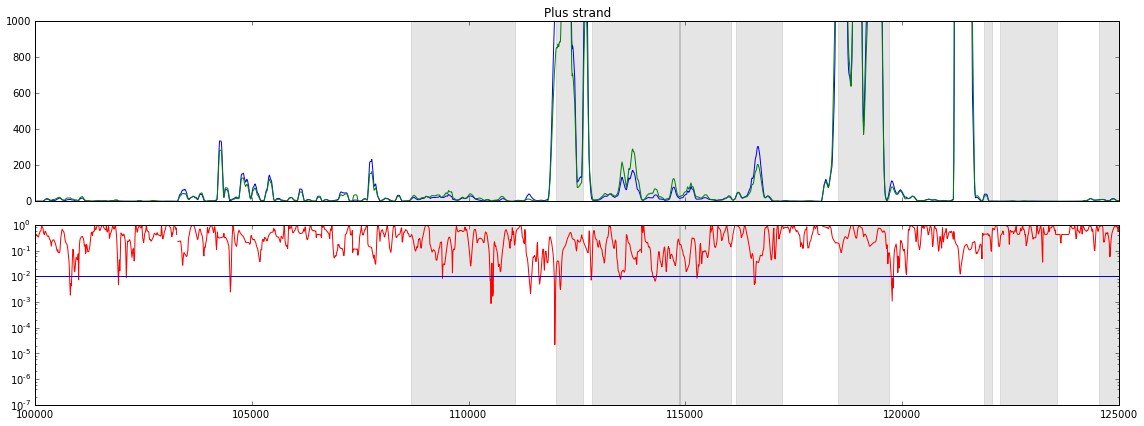

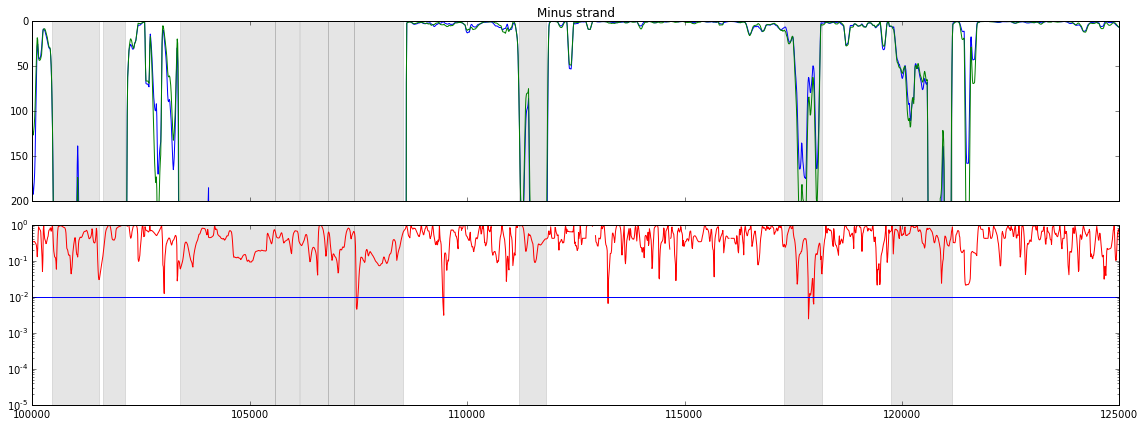

In [51]:
####Options
log_scale = False
# log_scale = True

# focus=False

focus=(100000, 125000)

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(211)
ax.set_title('Plus strand')
if log_scale:
    ax.semilogy(xcoords, ctrl_fpkm_avg_plus)
    ax.semilogy(xcoords, treatment_fpkm_avg_plus)
else:
    ax.plot(xcoords, ctrl_fpkm_avg_plus)
    ax.plot(xcoords, treatment_fpkm_avg_plus)
for feature in plus_features:
    ax.axvspan(feature[0], feature[1], facecolor='k', alpha=0.1)
ax.set_xticklabels('')
if focus:
    ax.set_xlim(focus[0], focus[1])
    ax.set_ylim(0, 1000)

ax = fig.add_subplot(212)
ax.semilogy(xcoords, p_vals_plus, 'r')
ax.axhline(0.01)
for feature in plus_features:
    ax.axvspan(feature[0], feature[1], facecolor='k', alpha=0.1)
if focus:
    ax.set_xlim(focus[0], focus[1])
plt.tight_layout()
    
    
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(211)
if log_scale:
    ax.semilogy(xcoords, ctrl_fpkm_avg_minus)
    ax.semilogy(xcoords, treatment_fpkm_avg_minus)
else:
    ax.plot(xcoords, ctrl_fpkm_avg_minus)
    ax.plot(xcoords, treatment_fpkm_avg_minus)
ax.set_title('Minus strand')
for feature in minus_features:
    ax.axvspan(feature[0], feature[1], facecolor='k', alpha=0.1)
ax.set_xticklabels('')
if focus:
    ax.set_xlim(focus[0], focus[1])
    ax.set_ylim(0, 200)
ax.invert_yaxis()




ax = fig.add_subplot(212)
ax.semilogy(xcoords, p_vals_minus, 'r')
ax.axhline(0.01)
for feature in minus_features:
    ax.axvspan(feature[0], feature[1], facecolor='k', alpha=0.1)
if focus:
    ax.set_xlim(focus[0], focus[1])
plt.tight_layout()